# CUSP-CORE MODEL: DARK MATTER HALO RESPONSE TO AN OUTFLOW

# 1/ Preamble

In [1]:
# IMPORTATIONS

import os
import sys
import time
import numpy as np
from matplotlib.pylab import *
from matplotlib import RcParams
from decimal import Decimal
import pickle
import inspect
import lmfit

import DM_profile as prf

/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# FIGURE PROPERTIES

fontsize=20
legendsize=fontsize
linewidth=2
linesize=5
ticksize=fontsize-4
figsize=(8,16)

rcParams['axes.linewidth'] = 1
rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 1
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

rcParams['figure.subplot.left']=0.15
rcParams['figure.subplot.right']=0.9
rcParams['figure.subplot.bottom']=0.15
rcParams['figure.subplot.top']=0.9
rcParams['figure.subplot.wspace']=0.1
rcParams['figure.subplot.hspace']=0.1

# 2/ Initial dark matter profile: Dekel-Zhao fit to NFW

In [29]:
# PARAMETERS

Rvir=150.       # virial radius [kpc]
Mvir=10**(12.5) # virial mass [Msun]
c=5.            # concentration


In [30]:
# DEFINE NFW PROFILE

xi=np.logspace(-2,0,101)
ri=xi*Rvir
rho_nfw=prf.rho_function(ri, (c, Rvir, Mvir), model='nfw')


In [31]:
# FIT WITH A DEKEL-ZHAO PROFILE

reload(prf)

params = lmfit.Parameters()
params.add('c',value= 5, min=1.e-16, vary=True)
params.add('a', value= 0,vary=True)
params.add('b', value= 2, vary=False)
params.add('g', value= 3, vary=False)
params.add('Rvir', value= float(Rvir), vary=False)
params.add('Mvir', value= float(Mvir), vary=False)

def min_res(params, r, data, w=1, model='dekel',verbose=False):
    p = prf.params2p(params, model)   
    fun = prf.rho_function(r, p, model)  
    err=w*(np.log10(fun) - np.log10(data))
    return err

result = lmfit.minimize(min_res, params, args=(ri,rho_nfw, 1., 'dekel'))
pfit = prf.result2p(result, 'dekel')
rhofit=prf.rho_function(ri, pfit, model='dekel')


Initial halo: Rvir=150 kpc, Mvir=3.2e+12 Msun,  s0.01=0.91,  c2=5.04


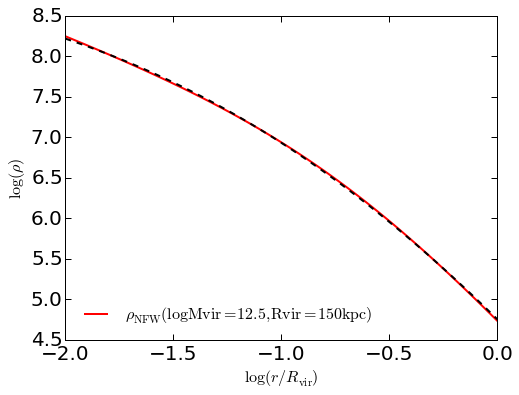

In [32]:
# PLOT

plt.figure(figsize=(8,6))
plt.plot(np.log10(ri/Rvir),np.log10(rho_nfw),'r',lw=2,label=r'$\rho_{\rm NFW} \rm (logMvir=%.1f, Rvir=%.0f kpc)$'%(np.log10(Mvir),Rvir))
plt.plot(np.log10(ri/pfit[4]),np.log10(rhofit),'k--',lw=2)

legend(frameon=False,loc='lower left',fontsize=16)
xlabel(r'$\log(r/R_{\rm vir})$',fontsize=16)
ylabel(r'$\log(\rho)$',fontsize=16)

#########

pi=pfit
(ci, ai, bi, gi, Rvir, Mvir) = pi
print 'Initial halo: Rvir=%.0f kpc,'%Rvir, 'Mvir=%.1e Msun, '%Mvir, 's0.01=%.2f, '%prf.s_function(0.01*Rvir,pi), 'c2=%.2f'%prf.c2_function(pi)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_rhoi.pdf')


# 3/ Initial central baryonic mass

In [33]:
# STELLAR TO HALO MASS RELATION FROM BEHROOZI (2013)

def lgMs_B13(Mvir,z):
    """
    stellar mass given halo mass [Msun] and redshift -- the fitting 
    function by Behroozi+13
    
    Syntax:
        Mstellar_B13(Mvir,z)
    where 
        Mvir: virial mass [Msun] (scalar or array)
        z: redshift (scalar)
    """
    a = 1./(1.+z)
    v = v_B13(a)
    e0 = -1.777
    ea = -0.006
    ez = 0.000
    ea2 = -0.119
    M0 = 11.514
    Ma = -1.793
    Mz = -0.251
    lge = e0 + (ea*(a-1.)+ez*z)*v + ea2*(a-1.)
    lgM = M0 + (Ma*(a-1.)+Mz*z)*v
    return lge+lgM + f_B13(np.log10(Mvir)-lgM,a) - f_B13(0.,a)

def v_B13(a):
    r"""
    auxiliary function for the Behroozi+13 Stellar-to-Halo-Mass Relation
    """
    return np.exp(-4.*a**2)

def f_B13(x,a):
    r"""
    auxiliary function for the Behroozi+13 Stellar-to-Halo-Mass Relation
    """
    a0 = -1.412
    aa = 0.731
    az = 0.0
    d0 = 3.508
    da = 2.608
    dz = -0.043
    g0 = 0.316
    ga = 1.319
    gz = 0.279
    v = v_B13(a)
    z = 1./a-1.
    alpha = a0 + (aa*(a-1.)+az*z)*v
    delta = d0 + (da*(a-1.)+dz*z)*v
    gamma = g0 + (ga*(a-1.)+gz*z)*v
    return delta * (np.log10(1.+np.exp(x)))**gamma / (1.+np.exp(10**(-x))) - \
        np.log10(1.+10**(alpha*x))


In [34]:
# STELLAR MASS AT THE CENTER FROM Behroozi (2013)

mtype='center'
logMstar=lgMs_B13(Mvir,2)
Mstar=10**logMstar

# GAS MASS
fgas=0.5
Mgas=fgas/(1.-fgas)*Mstar
logMgas=np.log10(Mgas)

# TOTAL BARYONIC MASS
Mbar=Mstar+Mgas
logMbar=np.log10(Mbar)

print 'logMstar= %.2f, logMgas=%.2f, logMbar=%.2f, fgas=%.2f'%(logMstar,logMgas,logMbar,fgas)


logMstar= 10.88, logMgas=10.88, logMbar=11.18, fgas=0.50


# 4/ Cusp-core model: effect of an outflow

In [35]:
reload(prf)

<module 'DM_profile' from 'DM_profile.pyc'>

In [36]:
# Minimization functions

def E_diff(ri, pi, pf,Mb=0,dMb=0,dE=0.,model='dekel',mtype='center',rm=0.,verbose=False):     
    Rvir=pi[4]
    Mvir=pi[5]
    ci=pi[0]
    ai=pi[1]
    Mi = prf.M_function(ri, pi,'dekel')
    xi=ri/Rvir
    
    cf=pf[0]
    af=pf[1]
    rf = prf.inv_M(Mi, pf, 'dekel') #the new radii that enclose the same masses
    xf = rf/Rvir
    
    Ut = prf.U_function(ri, pi, 'dekel')-prf.G*(Mb+dMb)/ri
    Uf = prf.U_function(rf, pf, 'dekel')-prf.G*(Mb+dMb)/rf
    Kt = prf.K_function(ri,pi, model='dekel',m=Mb,mtype=mtype,rm=rm)+dE
    Kf = prf.K_function(rf,pf, model='dekel',m=Mb+dMb,mtype=mtype,rm=rm)
    
    Et = Ut + Kt
    Ef = Uf + Kf
    
    if verbose:
        print 'p=',pf, 'slope=',prf.s_function(0.01*Rvir,pf), 'err=', np.mean((w*(Ef-Et))**2)    
    
    return array([Ef-Et, (Ef-Et)/abs(Et)],dtype=float)

def min_E_diff(paramsf, ri, pi, Mb=0,dMb=0, dE=0, w=1, model='dekel',mtype='center',rm=0.): 
    pf = prf.params2p(paramsf, 'dekel')
    return w*E_diff(ri, pi, pf,Mb=Mb, dMb=dMb,dE=dE,model=model,mtype=mtype,rm=rm)[0]


In [59]:
# FRACTION OF THE GAS REMOVED
eta=0.6

dM=-eta*Mgas
dE=0.


In [60]:
# INITIAL HALO

(ci, ai, bi, gi, Rvir, Mvir) = pi
xi=np.logspace(-2,0,100)
ri=xi*Rvir
logri=np.log10(xi)

rhoi=prf.rho_function(ri,pi)                                 # density [Msun kpc-3]
Mi = prf.M_function(ri, pi,'dekel')                          # dark matter mass [Msun]
dMi= np.diff(np.concatenate((np.array([0]),Mi)))            # shell mass [Msun]
Ui = prf.U_function(ri, pi, 'dekel')-prf.G*Mbar/ri           # shell potential energy per unit mass [kpc^2 Gyr^-2]
Ki = prf.K_function(ri,pi, model='dekel',m=Mbar,mtype=mtype) # shell kinetic energy per unit mass [kpc^2 Gyr^-2]

Kvir=prf.G*Mvir/(2*Mvir)                                     # virial kinetic energy per unit mass [kpc^2 Gyr^-2]


In [61]:
# OUT-OF-EQUILIBRIUM TRANSITIONAL STATE HALO (AFTER MASS CHANGE)

rhot=rhoi
Mt = Mi
Ut = prf.U_function(ri, pi, 'dekel')-prf.G*(Mbar+dM)/ri 
Kt = Ki


In [62]:
# RELAXATION

paramsf = lmfit.Parameters()
paramsf.add('c', value= ci, min=1e-16, vary=True)
paramsf.add('a', value= ai, max=3., vary=True)
paramsf.add('b', value= bi, vary=False)
paramsf.add('g', value= gi, vary=False)
paramsf.add('Rvir', value= float(Rvir), vary=False)
paramsf.add('Mvir', value= float(Mvir), vary=False)

result = lmfit.minimize(min_E_diff, paramsf, args=(ri, pi,Mbar,dM,dE,1.,'dekel','center',0.))
pf = prf.result2p(result,'dekel')


In [63]:
# FINAL RELAXED HALO

# Note: we here use ri as radial variable

rhof=prf.rho_function(ri,pf)
Uf = prf.U_function(ri, pf, 'dekel')-prf.G*(Mbar+dM)/ri
Kf = prf.K_function(ri,pf, model='dekel',m=(Mbar+dM),mtype='center',rm=0.)


In [64]:
print 'Initial:'
print '  ', 'Rvir=%.0f kpc,'%pi[4], 'Mvir=%.1e Msun, '%pi[5], 's0.01=%.2f, '%prf.s_function(0.01*pi[4],pi), 'c2=%.2f,'%prf.c2_function(pi), 'rcore=%.2f Rvir'%prf.xcore(pi)  
print ' '

print 'Final after feedback episode (eta=%.2f): '%eta
print '  ', 'Rvir=%.0f kpc,'%pi[4], 'Mvir=%.1e Msun, '%pf[5], 's0.01=%.2f, '%prf.s_function(0.01*pf[4],pf), 'c2=%.2f,'%prf.c2_function(pf), 'rcore=%.2f Rvir'%prf.xcore(pf)  



Initial:
   Rvir=150 kpc, Mvir=3.2e+12 Msun,  s0.01=0.91,  c2=5.04, rcore=0.01 Rvir
 
Final after feedback episode (eta=0.60): 
   Rvir=150 kpc, Mvir=3.2e+12 Msun,  s0.01=0.22,  c2=4.96, rcore=0.04 Rvir


# 5/ FIGURES

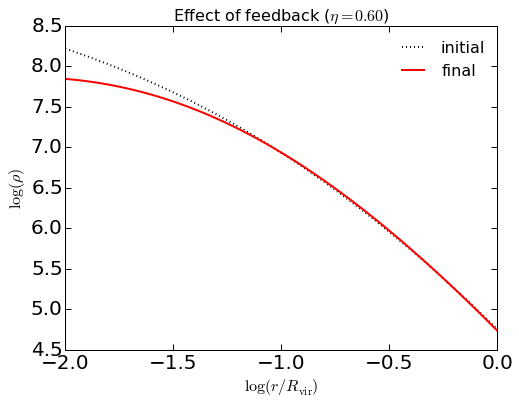

In [65]:
# DENSITY

plt.figure(figsize=(8,6))
plt.plot(logri,np.log10(rhoi),c='k',ls=':',lw=2,label='initial')
plt.plot(logri,np.log10(rhof),c='r',lw=2,label='final')

plt.legend(frameon=False,loc='best',fontsize=16)
plt.xlabel(r'$\log(r/R_{\rm vir})$',fontsize=16)
plt.ylabel(r'$\log(\rho)$',fontsize=16)
plt.title('Effect of feedback'+r' ($\eta=%.2f$)'%eta,fontsize=16)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_rhof.pdf')


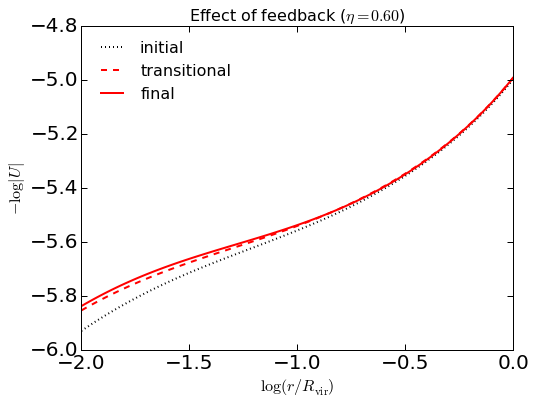

In [66]:
# POTENTIAL ENERGY

plt.figure(figsize=(8,6))
plt.plot(logri,-np.log10(-Ui),c='k',ls=':',lw=2,label='initial')
plt.plot(logri,-np.log10(-Ut),c='r',ls='--',lw=2,label='transitional')
plt.plot(logri,-np.log10(-Uf),c='r',lw=2,label='final')

plt.legend(frameon=False,loc='best',fontsize=16)
plt.xlabel(r'$\log(r/R_{\rm vir})$',fontsize=16)
plt.ylabel(r'$-\log|U|$',fontsize=16)
plt.title('Effect of feedback'+r' ($\eta=%.2f$)'%eta,fontsize=16)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_Uf.pdf')


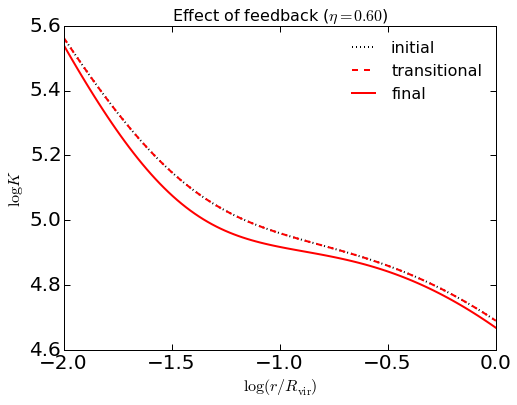

In [67]:
# KINETIC ENERGY

plt.figure(figsize=(8,6))
plt.plot(logri,np.log10(Ki),c='k',ls=':',lw=2,label='initial')
plt.plot(logri,np.log10(Kt),c='r',ls='--',lw=2,label='transitional')
plt.plot(logri,np.log10(Kf),c='r',lw=2,label='final')

plt.legend(frameon=False,loc='best',fontsize=16)
plt.xlabel(r'$\log(r/R_{\rm vir})$',fontsize=16)
plt.ylabel(r'$\log K$',fontsize=16)
plt.title('Effect of feedback'+r' ($\eta=%.2f$)'%eta,fontsize=16)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_Kf.pdf')


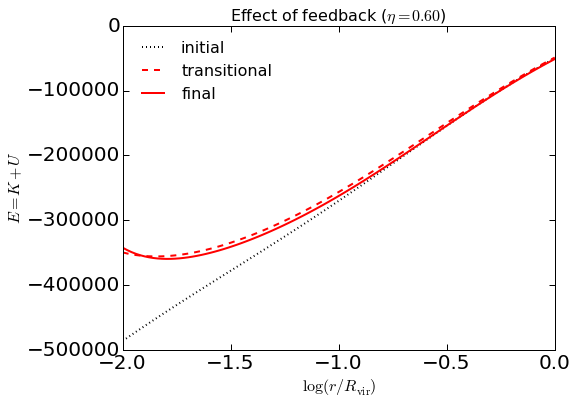

In [68]:
# TOTAL ENERGY

plt.figure(figsize=(8,6))
plt.plot(logri,Ki+Ui,c='k',ls=':',lw=2,label='initial')
plt.plot(logri,Kt+Ut,c='r',ls='--',lw=2,label='transitional')
plt.plot(logri,Kf+Uf,c='r',lw=2,label='final')

plt.legend(frameon=False,loc='best',fontsize=16)
plt.xlabel(r'$\log(r/R_{\rm vir})$',fontsize=16)
plt.ylabel(r'$E=K+U$',fontsize=16)
plt.title('Effect of feedback'+r' ($\eta=%.2f$)'%eta,fontsize=16)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_Ef.pdf')


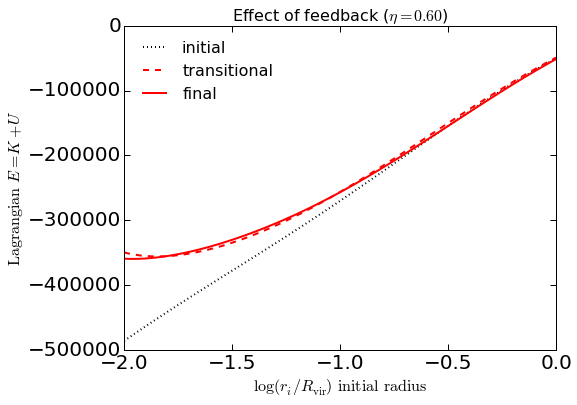

In [69]:
# TOTAL ENERGY FOR LAGRANGIAN SHELLS

rf = prf.inv_M(Mi, pf, 'dekel')
Uf_rf = prf.U_function(rf, pf, 'dekel')-prf.G*(Mbar+dM)/rf
Kf_rf = prf.K_function(rf,pf, model='dekel',m=(Mbar+dM),mtype='center',rm=0.)

plt.figure(figsize=(8,6))
plt.plot(logri,Ki+Ui,c='k',ls=':',lw=2,label='initial')
plt.plot(logri,Kt+Ut,c='r',ls='--',lw=2,label='transitional')
plt.plot(logri,Kf_rf+Uf_rf,c='r',lw=2,label='final')

plt.legend(frameon=False,loc='best',fontsize=16)
plt.xlabel(r'$\log(r_i/R_{\rm vir})$ $\rm initial$ $\rm radius$',fontsize=16)
plt.ylabel(r'$\rm Lagrangian$ $E=K+U$',fontsize=16)
plt.title('Effect of feedback'+r' ($\eta=%.2f$)'%eta,fontsize=16)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_Erf.pdf')


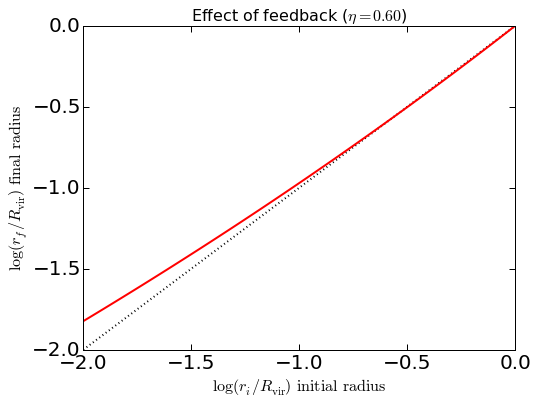

In [71]:
# RADIUS

plt.figure(figsize=(8,6))
plt.plot(logri,logri,c='k',ls=':',lw=2)
plt.plot(logri,np.log10(rf/Rvir),c='r',lw=2)

plt.xlabel(r'$\log(r_i/R_{\rm vir})$ $\rm initial$ $\rm radius$',fontsize=16)
plt.ylabel(r'$\log(r_f/R_{\rm vir})$ $\rm final$ $\rm radius$',fontsize=16)
plt.title('Effect of feedback'+r' ($\eta=%.2f$)'%eta,fontsize=16)

plt.savefig('/cs/sci/freundlich/CUSPCORE/CUSPCORE_STAGE/CC_rf.pdf')
